# Estimation of Timelags in Translation from Clinical Trials to Clinical Guidelines

In [1]:
from api.app import app
from fastapi.testclient import TestClient
import os

with TestClient(app) as client:
    # Initialize state
    pass    

session = app.state.session()

In [2]:
import pandas as pd
from pathlib import Path

def load_df(base_path):
    annos = pd.read_csv(base_path / 'predictions/silver_standard_entities_linked_xmen.tsv', sep='\t')
    annos['guideline_id'] = annos.document.map(lambda s: s[3:-5]) 
    meta = pd.read_csv(base_path / 'plain_text' / 'metadata_index.tsv', sep='\t')
    return pd.merge(annos, meta.drop(columns=['guideline_id']), left_on='document', right_on='file')

In [3]:
base_20 = Path('data/ggponc/v2.0_2022_03_24')
base_21 = Path('data/ggponc/v2.1_2023_03_30')
base_22 = Path('data/ggponc/v2.2_2024_04_22')
base_23 = Path('data/ggponc/v2.3_2024_06_18')

In [4]:
dfs = { p.name : load_df(p) for p in [base_20, base_21, base_22, base_23] }

In [5]:
versions = list(dfs.keys())
versions

['v2.0_2022_03_24', 'v2.1_2023_03_30', 'v2.2_2024_04_22', 'v2.3_2024_06_18']

In [6]:
for d in versions:
    print(d, len(dfs[d]))

v2.0_2022_03_24 225977
v2.1_2023_03_30 257325
v2.2_2024_04_22 275037
v2.3_2024_06_18 277676


In [7]:
guidelines = dfs[max(versions)].guideline_id.unique()
list(guidelines)

['mundhoehlenkarzinom',
 'magenkarzinom',
 'kolorektales-karzinom',
 'lungenkarzinom',
 'praevention-zervixkarzinom',
 'zervixkarzinom',
 'hautkrebspraevention',
 'malignes-melanom',
 'aktinische-keratose-und-plattenepithelkarzinom-der-haut',
 'mammakarzinom',
 'pankreaskarzinom',
 'hepatozellulaeres-karzinom-und-biliaere-karzinome',
 'nierenzellkarzinom',
 'oesophaguskarzinom',
 'larynxkarzinom',
 'endometriumkarzinom',
 'maligne-ovarialtumoren',
 'chronisch-lymphatische-leukaemie-cll',
 'hodgkin-lymphom',
 'follikulaeres-lymphom',
 'harnblasenkarzinom',
 'hodentumoren',
 'prostatakarzinom',
 'peniskarzinom',
 'analkarzinom',
 'psychoonkologie',
 'palliativmedizin',
 'supportive-therapie',
 'komplementaermedizin',
 'adulte-weichgewebesarkome',
 'multiples-myelom',
 'dlbcl',
 'oro--und-hypopharynxkarzinom',
 'pomgat']

In [8]:
import yaml
version_config = yaml.safe_load(open('data/topic_versions.yaml'))

In [9]:
update_df = []

for i, (guideline_id, v) in enumerate(version_config.items()):
    gl_versions = sorted(v['versions'].keys())
    for v1, v2 in zip(gl_versions, gl_versions[1:]):
        print(i, guideline_id, v1, v2)
        ggponc_v1 = v['versions'][v1]['ggponc']
        ggponc_v2 = v['versions'][v2]['ggponc']
        if not ggponc_v1 or not ggponc_v2:
            continue
        df_gl_cur = dfs[ggponc_v2].query('guideline_id == @guideline_id')    
        df_gl_prev = dfs[ggponc_v1].query('guideline_id == @guideline_id')

        update_df.append(
            {
                'guideline_id' : guideline_id,
                'cur_release' :  ggponc_v2,
                'cur_release_date' : v['versions'][v2]['date'],
                'cur_version' : v2,
                'cur_n_ents' : len(df_gl_cur),
                'cur_n_recs' : df_gl_cur.recommendation.sum(),
                'cur_max_rec_date' : df_gl_cur.recommendation_creation_date.dropna().max(),
                'prev_release' : ggponc_v1,
                'prev_release_date' : v['versions'][v1]['date'],
                'prev_version' : v1,
                'prev_n_ents' : len(df_gl_prev),
                'prev_n_recs' : df_gl_prev.recommendation.sum(),
                'prev_max_rec_date' : df_gl_prev.recommendation_creation_date.dropna().max(),
            }
        )
        
    if len(gl_versions) ==1:
        print(i, gl_versions[0], 'No Update')
        
    
update_df = pd.DataFrame(update_df).set_index(['guideline_id', 'cur_version' ])
update_df = update_df[update_df.prev_n_ents > 0]
update_df

0 adulte-weichgewebesarkome 1.0 1.1
1 aktinische-keratose-und-plattenepithelkarzinom-der-haut 1.1 2.0
2 1.2 No Update
3 1.0 No Update
4 1.0 No Update
5 endometriumkarzinom 1.0 2.0
6 1.0 No Update
7 2.0 No Update
8 hepatozellulaeres-karzinom-und-biliaere-karzinome 2.0 3.0
8 hepatozellulaeres-karzinom-und-biliaere-karzinome 3.0 4.0
9 1.1 No Update
10 hodgkin-lymphom 3.1 3.2
11 2.1 No Update
12 1.1 No Update
13 lungenkarzinom 1.0 2.0
13 lungenkarzinom 2.0 3.0
14 2.0 No Update
15 maligne-ovarialtumoren 5.0 5.1
16 3.3 No Update
17 4.4 No Update
18 1.0 No Update
19 3.0 No Update
20 nierenzellkarzinom 3.0 4.0
21 1.0 No Update
22 oesophaguskarzinom 3.0 3.1
22 oesophaguskarzinom 3.1 4.0
23 pankreaskarzinom 1.0 2.0
23 pankreaskarzinom 2.0 3.0
24 1.0 No Update
25 prostatakarzinom 6.2 7.0
26 zervixkarzinom 2.1 2.2


cur_release  \
guideline_id                                       cur_version                    
adulte-weichgewebesarkome                          1.1          v2.1_2023_03_30   
aktinische-keratose-und-plattenepithelkarzinom-... 2.0          v2.1_2023_03_30   
endometriumkarzinom                                2.0          v2.1_2023_03_30   
hepatozellulaeres-karzinom-und-biliaere-karzinome  3.0          v2.1_2023_03_30   
                                                   4.0          v2.2_2024_04_22   
hodgkin-lymphom                                    3.2          v2.1_2023_03_30   
lungenkarzinom                                     2.0          v2.1_2023_03_30   
                                                   3.0          v2.2_2024_04_22   
maligne-ovarialtumoren                             5.1          v2.1_2023_03_30   
nierenzellkarzinom                                 4.0          v2.1_2023_03_30   
oesophaguskarzinom                                 3.1          v2.1_2023_03_30   
                                                   4.0          v2.2_2024_04_22   
pankreaskarzinom                                   3.0          v2.2_2024_04_22   
prostatakarzinom                                   7.0          v2.3_2024_06_18   
zervixkarzinom                                     2.2          v2.1_2023_03_30   

                                                               cur_release_date  \
guideline_id                                       cur_version                    
adulte-weichgewebesarkome                          1.1               2022-06-01   
aktinische-keratose-und-plattenepithelkarzinom-... 2.0               2022-12-01   
endometriumkarzinom                                2.0               2022-09-01   
hepatozellulaeres-karzinom-und-biliaere-karzinome  3.0               2022-07-01   
                                                   4.0               2023-08-01   
hodgkin-lymphom                                    3.2               2022-10-01   
lungenkarzinom                                     2.0               2022-11-01   
                                                   3.0               2024-03-01   
maligne-ovarialtumoren                             5.1               2022-05-01   
nierenzellkarzinom                                 4.0               2023-02-01   
oesophaguskarzinom                                 3.1               2022-06-01   
                                                   4.0               2023-12-01   
pankreaskarzinom                                   3.0               2024-03-01   
prostatakarzinom                                   7.0               2024-05-01   
zervixkarzinom                                     2.2               2022-03-01   

                                                                cur_n_ents  \
guideline_id                                       cur_version               
adulte-weichgewebesarkome                          1.1                7452   
aktinische-keratose-und-plattenepithelkarzinom-... 2.0                9103   
endometriumkarzinom                                2.0                8887   
hepatozellulaeres-karzinom-und-biliaere-karzinome  3.0                5748   
                                                   4.0                6485   
hodgkin-lymphom                                    3.2                5045   
lungenkarzinom                                     2.0               16596   
                                                   3.0               17420   
maligne-ovarialtumoren                             5.1                3633   
nierenzellkarzinom                                 4.0                7612   
oesophaguskarzinom                                 3.1                5339   
                                                   4.0                5859   
pankreaskarzinom                                   3.0                5268   
prostatakarzinom                                   7.0               10448

In [10]:
from IPython.display import display, Markdown

#intv_type = ['Clinical_Drug', 'Therapeutic', 'Diagnostic']

new_intv_df = []
threshold = 0.1

for (guideline_id, cur_version), r in update_df.iterrows():
    prev_version = r.prev_release
    current_version = r.cur_release

    df_before_gl = dfs[prev_version].query('guideline_id == @guideline_id')
    df_after_gl = dfs[current_version].query('guideline_id == @guideline_id & recommendation')

    interventions_before_gl_set = set(df_before_gl.cui.values)
    interventions_after_new = df_after_gl[(df_after_gl.confidence > threshold) & ~df_after_gl.cui.isin(interventions_before_gl_set)] #& df_after_gl.tuis.map(eval).map(lambda tuis: any([t in intv_tuis for t in tuis]))
    interventions_after_new = interventions_after_new.drop_duplicates(subset=['type', 'cui']).copy()
    interventions_after_new['cur_version'] = cur_version
    interventions_after_new['prev_version'] = prev_version
    for c in r.index:
        interventions_after_new[c] = r[c]
    new_intv_df.append(interventions_after_new)
  
cols = ['guideline_id', 'prev_version', 'cur_version', 'document', 'text', 'type', 'cui', 'tuis', 'canonical', 'confidence', 'file', 'number', 'recommendation_grade', 'type_of_recommendation', 'cur_release_date', 'cur_release', 'prev_release']
new_intv_df = pd.concat(new_intv_df)[cols]

In [11]:
new_intv_df

,guideline_id,prev_version,cur_version,document,text,type,cui,tuis,canonical,confidence,file,number,recommendation_grade,type_of_recommendation,cur_release_date,cur_release,prev_release
65870,aktinische-keratose-und-plattenepithelkarzinom...,1.1,2.0,08_aktinische-keratose-und-plattenepithelkarzi...,AKASI,Diagnostic,C0639811,['T109'],"aqua(1,10-phenanthroline)(phenylalaninato)copp...",0.100395,08_aktinische-keratose-und-plattenepithelkarzi...,4.20,NaN,evidencebased-statement,2022-12-01,v2.1_2023_03_30,v2.0_2022_03_24
66086,aktinische-keratose-und-plattenepithelkarzinom...,1.1,2.0,08_aktinische-keratose-und-plattenepithelkarzi...,Spindelzelliges (sarkomatoides) Plattenepithel...,Diagnosis_or_Pathology,C0349656,['T191'],Sarkomatoides Plattenepithelkarzinom,0.117381,08_aktinische-keratose-und-plattenepithelkarzi...,4.80,NaN,consensbased-statement,2022-12-01,v2.1_2023_03_30,v2.0_2022_03_24
66962,aktinische-keratose-und-plattenepithelkarzinom...,1.1,2.0,08_aktinische-keratose-und-plattenepithelkarzi...,einzelne oder multiple aktinische Keratosen,Diagnosis_or_Pathology,C1274598,['T047'],Multiple actinic keratoses,0.163462,08_aktinische-keratose-und-plattenepithelkarzi...,5.30,b,evidencebased-recommendation,2022-12-01,v2.1_2023_03_30,v2.0_2022_03_24
71528,aktinische-keratose-und-plattenepithelkarzinom...,1.1,2.0,08_aktinische-keratose-und-plattenepithelkarzi...,entzündlichen Dermatose,Diagnosis_or_Pathology,C3875321,['T047'],Inflammatory dermatosis,0.111934,08_aktinische-keratose-und-plattenepithelkarzi...,7.10,a,consensbased-recommendation,2022-12-01,v2.1_2023_03_30,v2.0_2022_03_24
116910,endometriumkarzinom,1.0,2.0,15_endometriumkarzinom_0037,Myome,Diagnosis_or_Pathology,C0027086,['T191'],Myoma,0.133710,15_endometriumkarzinom_0037,4.80,b,consensbased-recommendation,2022-09-01,v2.1_2023_03_30,v2.0_2022_03_24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173698,prostatakarzinom,6.2,7.0,22_prostatakarzinom_0281,homologen Rekombinationsreparatur,Nutrient_or_Body_Substance,C1158513,['T045'],DNA-Rekombinationsreparatur,0.146210,22_prostatakarzinom_0281,7.42,NaN,consensbased-recommendation,2024-05-01,v2.3_2024_06_18,v2.0_2022_03_24
173719,prostatakarzinom,6.2,7.0,22_prostatakarzinom_0282,zugrundeliegende homologen Rekombinationsrepar...,Diagnosis_or_Pathology,C1158512,['T045'],Homologous Recombination Repair,0.137996,22_prostatakarzinom_0282,7.43,NaN,consensbased-recommendation,2024-05-01,v2.3_2024_06_18,v2.0_2022_03_24
174228,prostatakarzinom,6.2,7.0,22_prostatakarzinom_0290,Vipivotidtetraxetan,External_Substance,C5238124,"['T116', 'T121', 'T129']",Vipivotide Tetraxetan,0.165582,22_prostatakarzinom_0290,7.47,a,evidencebased-recommendation,2024-05-01,v2.3_2024_06_18,v2.0_2022_03_24
174554,prostatakarzinom,6.2,7.0,22_prostatakarzinom_0299,Chromogranin A,Nutrient_or_Body_Substance,C0055633,"['T125', 'T130']",Chromogranin A,0.140005,22_prostatakarzinom_0299,7.53,NaN,consensbased-recommendation,2024-05-01,v2.3_2024_06_18,v2.0_2022_03_24


In [12]:
intervention_tree_numbers = ('A1.4.1.1.1', 'B1.3.1.3')

In [13]:
def is_intervention_type(cui):
    for t in app.state.concept_parser.umls_parser.get_semantic_types(cui):
        if t['STN'].startswith(intervention_tree_numbers):
            return True
    return False

In [14]:
new_intv_df = new_intv_df[new_intv_df.cui.map(is_intervention_type)]
len(new_intv_df)

38

In [15]:
new_intv_df

,guideline_id,prev_version,cur_version,document,text,type,cui,tuis,canonical,confidence,file,number,recommendation_grade,type_of_recommendation,cur_release_date,cur_release,prev_release
118147,endometriumkarzinom,1.0,2.0,15_endometriumkarzinom_0099,alleinige Verwendung molekularpathologischer M...,Diagnostic,C5205681,['T061'],Single-agent Therapeutic Regimens,0.100280,15_endometriumkarzinom_0099,4.370,a,consensbased-recommendation,2022-09-01,v2.1_2023_03_30,v2.0_2022_03_24
122378,endometriumkarzinom,1.0,2.0,15_endometriumkarzinom_0271,Trastuzumab,Clinical_Drug,C0728747,"['T116', 'T121', 'T129']",Trastuzumab,0.126775,15_endometriumkarzinom_0271,9.180,0,evidencebased-recommendation,2022-09-01,v2.1_2023_03_30,v2.0_2022_03_24
122398,endometriumkarzinom,1.0,2.0,15_endometriumkarzinom_0273,Dostarlimab,Clinical_Drug,C5242455,"['T116', 'T121', 'T129']",Dostarlimab-containing product,0.116009,15_endometriumkarzinom_0273,9.200,0,evidencebased-recommendation,2022-09-01,v2.1_2023_03_30,v2.0_2022_03_24
122399,endometriumkarzinom,1.0,2.0,15_endometriumkarzinom_0273,Pembrolizumab,Clinical_Drug,C3658706,"['T116', 'T121', 'T129']",Product containing pembrolizumab (medicinal pr...,0.123560,15_endometriumkarzinom_0273,9.200,0,evidencebased-recommendation,2022-09-01,v2.1_2023_03_30,v2.0_2022_03_24
124356,endometriumkarzinom,1.0,2.0,15_endometriumkarzinom_0346,MBSR,Therapeutic,C4527300,['T061'],Meditation-Based Stress Reduction (Breast Cancer),0.122744,15_endometriumkarzinom_0346,11.210,b,evidencebased-recommendation,2022-09-01,v2.1_2023_03_30,v2.0_2022_03_24
124358,endometriumkarzinom,1.0,2.0,15_endometriumkarzinom_0347,Yoga,Therapeutic,C1883583,['T061'],Joga,0.125578,15_endometriumkarzinom_0347,11.220,b,evidencebased-recommendation,2022-09-01,v2.1_2023_03_30,v2.0_2022_03_24
97299,hepatozellulaeres-karzinom-und-biliaere-karzinome,3.0,4.0,11_hepatozellulaeres-karzinom-und-biliaere-kar...,Durvalumab,Clinical_Drug,C4055109,"['T116', 'T121', 'T129']",Durvalumab,0.142739,11_hepatozellulaeres-karzinom-und-biliaere-kar...,3.710,NaN,evidencebased-statement,2023-08-01,v2.2_2024_04_22,v2.1_2023_03_30
97300,hepatozellulaeres-karzinom-und-biliaere-karzinome,3.0,4.0,11_hepatozellulaeres-karzinom-und-biliaere-kar...,Tremelimumab,Clinical_Drug,C2351038,"['T116', 'T121', 'T129']",ticilimumab,0.150178,11_hepatozellulaeres-karzinom-und-biliaere-kar...,3.710,NaN,evidencebased-statement,2023-08-01,v2.2_2024_04_22,v2.1_2023_03_30
25489,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0284,Durvalumab,Clinical_Drug,C4055109,"['T116', 'T121', 'T129']",Durvalumab,0.142960,03_lungenkarzinom_0284,8.490,a,evidencebased-recommendation,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24
26544,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0313,Cemiplimab,Clinical_Drug,C4724806,"['T116', 'T121', 'T129']",Cemiplimab (substance),0.150689,03_lungenkarzinom_0313,8.640,0,evidencebased-recommendation,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24


In [16]:
new_intv_df = new_intv_df.drop_duplicates(subset=['guideline_id', 'cui'])
# Remove generic concepts
new_intv_df = new_intv_df[~new_intv_df.cui.isin([
    'C4087148', 'C2986423', 'C0013218', 'C4524032', 'C0596581', 'C0015133', 'C0242739',
    'C4684977', 'C2347669', 'C5392215', 'C0023764', 'C0002712', 'C4733472', 'C5205681', 'C4684960'
])]

In [17]:
len(new_intv_df)

29

In [18]:
new_intv_df.columns

Index(['guideline_id', 'prev_version', 'cur_version', 'document', 'text',
       'type', 'cui', 'tuis', 'canonical', 'confidence', 'file', 'number',
       'recommendation_grade', 'type_of_recommendation', 'cur_release_date',
       'cur_release', 'prev_release'],
      dtype='object')

In [19]:
from tqdm.auto import tqdm
from api.app import EvidenceQuery, get_evidence_by_population, get_evidence_grouped_df, get_topics

def get_date(edf, phase, start):
    date = 'start_date' if start else 'result_date'
    if phase == '3':
        p_edf = edf.query('max_phase == 3').dropna(subset=date)
    else:
        p_edf = edf.query('max_phase in [1,2]').dropna(subset=date)
    if len(p_edf) == 0:
        return None
    else:
        return p_edf.sort_values(date).iloc[0][date]

diff_stats = []
    
for i, r in tqdm(new_intv_df.iterrows()):
    cui = r.cui
    guideline_id = r.guideline_id
    
    q = EvidenceQuery(guideline_id=guideline_id, 
                      cuis_intervention=[cui],
                      sources=['pubmed', 'clinicaltrials'],
                      exclude_children=True)
    
    edf = get_evidence_grouped_df(q, False, session)
    if edf is not None:
        edf = edf[edf.group.astype(str).str.startswith('NCT')]
    
    has_results = (edf is not None) and (len(edf) > 0)
    
    if has_results: # ignore any dates past guideline publication
    #    edf.loc[edf.result_date > r.cur_release_date, 'result_date'] = None
        edf.loc[edf.start_date > r.cur_release_date, 'start_date'] = None
    
    
    start_phase_12 = get_date(edf, phase='1-2', start=True) if has_results else None
    #start_phase_2 = get_date(edf, phase=2, start=True) if has_results else None
    start_phase_3 = get_date(edf, phase='3', start=True) if has_results else None
    result_phase_12 = get_date(edf, phase='1-2', start=False) if has_results else None
    #result_phase_2 = get_date(edf, phase=2, start=False) if has_results else None
    result_phase_3 = get_date(edf, phase='3', start=False) if has_results else None
    
    res = {
        'results_available' : has_results,
        'start_phase_12' : start_phase_12,
        'result_phase_12' : result_phase_12,
        #'start_phase_2' : start_phase_2,
        #'result_phase_2' : result_phase_2,
        'start_phase_3' : start_phase_3,
        'result_phase_3' : result_phase_3,
    }
    for c in r.index:
        res[c] = r[c]
    
    diff_stats.append(res)
diff_stats = pd.DataFrame(diff_stats)

0it [00:00, ?it/s]

In [20]:
diff_stats.columns

Index(['results_available', 'start_phase_12', 'result_phase_12',
       'start_phase_3', 'result_phase_3', 'guideline_id', 'prev_version',
       'cur_version', 'document', 'text', 'type', 'cui', 'tuis', 'canonical',
       'confidence', 'file', 'number', 'recommendation_grade',
       'type_of_recommendation', 'cur_release_date', 'cur_release',
       'prev_release'],
      dtype='object')

In [21]:
diff_stats[['guideline_id', 'prev_version', 'cur_version', 'cui', 'text', 'canonical', 'cur_release_date', 
            'results_available', 'start_phase_12', 'result_phase_12', 'start_phase_3', 'result_phase_3']]

,guideline_id,prev_version,cur_version,cui,text,canonical,cur_release_date,results_available,start_phase_12,result_phase_12,start_phase_3,result_phase_3
0,endometriumkarzinom,1.0,2.0,C0728747,Trastuzumab,Trastuzumab,2022-09-01,True,2011-06-30,2018-07-01,None,None
1,endometriumkarzinom,1.0,2.0,C5242455,Dostarlimab,Dostarlimab-containing product,2022-09-01,True,2016-03-07,2020-11-01,2019-07-18,2023-06-01
2,endometriumkarzinom,1.0,2.0,C3658706,Pembrolizumab,Product containing pembrolizumab (medicinal pr...,2022-09-01,True,2014-07-17,2019-05-01,2018-06-11,2021-11-17
3,endometriumkarzinom,1.0,2.0,C4527300,MBSR,Meditation-Based Stress Reduction (Breast Cancer),2022-09-01,False,None,None,None,None
4,endometriumkarzinom,1.0,2.0,C1883583,Yoga,Joga,2022-09-01,False,None,None,None,None
5,hepatozellulaeres-karzinom-und-biliaere-karzinome,3.0,4.0,C4055109,Durvalumab,Durvalumab,2023-08-01,True,2012-09-05,2019-03-01,2017-10-11,2022-08-01
6,hepatozellulaeres-karzinom-und-biliaere-karzinome,3.0,4.0,C2351038,Tremelimumab,ticilimumab,2023-08-01,True,2008-12-31,2013-07-01,2017-10-11,2022-08-01
7,lungenkarzinom,1.0,2.0,C4055109,Durvalumab,Durvalumab,2022-11-01,True,2012-09-05,2016-03-01,2014-05-07,2017-11-01
8,lungenkarzinom,1.0,2.0,C4724806,Cemiplimab,Cemiplimab (substance),2022-11-01,True,2015-02-02,2021-05-01,2017-05-29,2021-02-01
9,lungenkarzinom,1.0,2.0,C4727545,Nivolumab + Ipilimumab über 2 Zyklen,Ipilimumab/Nivolumab Regimen,2022-11-01,True,2013-10-24,2016-07-01,2014-10-31,2019-10-22


In [22]:
import pandas as pd
import numpy as np

diff_stats_res = diff_stats.copy()

for phase in ['12', '3']:   
    for s in ('start', 'result'):
        d = f'{s}_phase_{phase}'
        diff_stats_res['diff_' + d] = (diff_stats_res.cur_release_date - diff_stats[d])
#        diff_stats_res.loc[~diff_stats_res.results_available | (diff_stats_res[d] > diff_stats_res.cur_release_date), 'diff_' + d] = None
    diff_stats_res['diff_phase_123'] = diff_stats_res.result_phase_3 - diff_stats_res.start_phase_12
    diff_stats_res['diff_phase_12'] = diff_stats_res.result_phase_12 - diff_stats_res.start_phase_12
    diff_stats_res['diff_phase_3'] = diff_stats_res.result_phase_3 - diff_stats_res.start_phase_3
diff_stats_res = diff_stats_res[~diff_stats_res.diff_phase_12.isna() | ~diff_stats_res.diff_phase_3.isna()]
#diff_stats_res
diff_stats_res[['guideline_id', 'cui', 'text', 'cur_release'] + [c for c in diff_stats_res.columns if 'phase' in c]]

,guideline_id,cui,text,cur_release,start_phase_12,result_phase_12,start_phase_3,result_phase_3,diff_start_phase_12,diff_result_phase_12,diff_phase_123,diff_phase_12,diff_phase_3,diff_start_phase_3,diff_result_phase_3
0,endometriumkarzinom,C0728747,Trastuzumab,v2.1_2023_03_30,2011-06-30,2018-07-01,None,None,4081 days,1523 days,NaT,2558 days,NaT,NaT,NaT
1,endometriumkarzinom,C5242455,Dostarlimab,v2.1_2023_03_30,2016-03-07,2020-11-01,2019-07-18,2023-06-01,2369 days,669 days,2642 days,1700 days,1414 days,1141 days,-273 days
2,endometriumkarzinom,C3658706,Pembrolizumab,v2.1_2023_03_30,2014-07-17,2019-05-01,2018-06-11,2021-11-17,2968 days,1219 days,2680 days,1749 days,1255 days,1543 days,288 days
5,hepatozellulaeres-karzinom-und-biliaere-karzinome,C4055109,Durvalumab,v2.2_2024_04_22,2012-09-05,2019-03-01,2017-10-11,2022-08-01,3982 days,1614 days,3617 days,2368 days,1755 days,2120 days,365 days
6,hepatozellulaeres-karzinom-und-biliaere-karzinome,C2351038,Tremelimumab,v2.2_2024_04_22,2008-12-31,2013-07-01,2017-10-11,2022-08-01,5326 days,3683 days,4961 days,1643 days,1755 days,2120 days,365 days
7,lungenkarzinom,C4055109,Durvalumab,v2.1_2023_03_30,2012-09-05,2016-03-01,2014-05-07,2017-11-01,3709 days,2436 days,1883 days,1273 days,1274 days,3100 days,1826 days
8,lungenkarzinom,C4724806,Cemiplimab,v2.1_2023_03_30,2015-02-02,2021-05-01,2017-05-29,2021-02-01,2829 days,549 days,2191 days,2280 days,1344 days,1982 days,638 days
9,lungenkarzinom,C4727545,Nivolumab + Ipilimumab über 2 Zyklen,v2.1_2023_03_30,2013-10-24,2016-07-01,2014-10-31,2019-10-22,3295 days,2314 days,2189 days,981 days,1817 days,2923 days,1106 days
11,lungenkarzinom,C5446297,Amivantamab,v2.1_2023_03_30,2016-05-24,2021-10-01,2020-09-30,2023-11-01,2352 days,396 days,2717 days,1956 days,1127 days,762 days,-365 days
12,lungenkarzinom,C4080091,Lorlatinib,v2.1_2023_03_30,2014-01-08,2016-01-01,2015-12-16,2018-12-07,3219 days,2496 days,1794 days,723 days,1087 days,2512 days,1425 days


In [23]:
ix = diff_stats_res.set_index(['guideline_id', 'prev_version', 'cur_version'])
for gl, prev_version, cur_version in ix.index.unique():
    print(gl, '&', prev_version, '$\\blacktriangleright$', cur_version, '&', ', '.join(ix.loc[gl, prev_version, cur_version].text) )

endometriumkarzinom & 1.0 $\blacktriangleright$ 2.0 & Trastuzumab, Dostarlimab, Pembrolizumab
hepatozellulaeres-karzinom-und-biliaere-karzinome & 3.0 $\blacktriangleright$ 4.0 & Durvalumab, Tremelimumab
lungenkarzinom & 1.0 $\blacktriangleright$ 2.0 & Durvalumab, Cemiplimab, Nivolumab + Ipilimumab über 2 Zyklen, Amivantamab, Lorlatinib, Entrectinib, Repotrectinib, Larotrectinib, Selpercatinib, Pralsetinib, Capmatinib, Sotorasib
oesophaguskarzinom & 3.0 $\blacktriangleright$ 3.1 & Nivolumab, Pembrolizumab
pankreaskarzinom & 2.0 $\blacktriangleright$ 3.0 & niedermolekularen Heparin
prostatakarzinom & 6.2 $\blacktriangleright$ 7.0 & Niraparib, Talazoparib


In [24]:
import numpy as np
diff_cols = ['diff_phase_12', 'diff_phase_3', 'diff_phase_123', 'diff_result_phase_3', 'diff_result_phase_12', 'diff_start_phase_12']
diff_stats_years = diff_stats_res.copy()
diff_stats_years[diff_cols] = diff_stats_res[diff_cols] / np.timedelta64(1, "Y")

In [25]:
diff_stats_years[diff_stats_years.diff_phase_3.isna()][diff_cols].describe()

,diff_phase_12,diff_phase_3,diff_phase_123,diff_result_phase_3,diff_result_phase_12,diff_start_phase_12
count,7.000000,0.0,0.0,0.0,7.000000,7.000000
mean,6.409049,NaN,NaN,NaN,3.036730,9.445779
std,1.718244,NaN,NaN,NaN,4.304808,5.589440
min,4.120550,NaN,NaN,NaN,-1.166348,5.204761
25%,5.481290,NaN,NaN,NaN,0.584543,5.640088
50%,6.820126,NaN,NaN,NaN,1.336099,6.951546
75%,6.935118,NaN,NaN,NaN,4.084957,10.922880
max,9.089851,NaN,NaN,NaN,11.748359,20.838210


In [26]:
diff_stats_years[~diff_stats_years.diff_phase_3.isna()][diff_cols].describe()

,diff_phase_12,diff_phase_3,diff_phase_123,diff_result_phase_3,diff_result_phase_12,diff_start_phase_12
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,4.363676,3.909914,7.428124,1.447440,4.511888,8.875564
std,1.435913,0.783077,3.012725,1.891063,3.019264,3.119099
min,1.979507,2.737907,4.509333,-0.999336,1.084211,4.180784
25%,3.367626,3.288226,5.970006,0.229984,2.208122,6.655852
50%,4.654442,3.704388,6.250642,0.999336,3.666057,8.602504
75%,5.145896,4.713307,7.388242,2.818675,6.502529,10.161742
max,6.483364,4.974777,14.666968,4.999418,10.749023,15.584167


In [27]:
col_map = {
    'Overall' : 'diff_start_phase_12',
    'Phase I/II\nstart → end' : 'diff_phase_12',
    'Phase III\nstart → end': 'diff_phase_3',
    'Phase I/II\nend → guideline': 'diff_result_phase_12',
    'Phase III\nend → guideline': 'diff_result_phase_3',
}

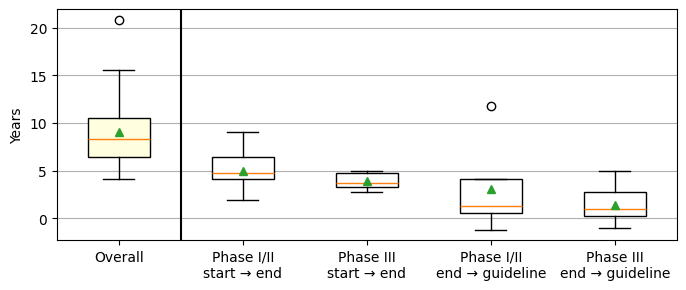

In [28]:
from matplotlib import pyplot as plt

data = []

f, ax = plt.subplots(1, 1, figsize=(8,3))

for c in col_map.values():
    if c == 'diff_result_phase_12': 
        vals = diff_stats_years[diff_stats_years.diff_result_phase_3.isna()][c].dropna().values
    else:
        vals = diff_stats_years[c].dropna().values
    data.append(vals)
    
bp = ax.boxplot(data, showmeans=True, patch_artist=True)
ax.grid(axis='y')
ax.set_xticklabels(col_map.keys())
ax.set_ylabel('Years')
ax.axvline(1.5, color='black')

# Define colors for each group
colors = ['lightyellow', 'white', 'white', 'white', 'white']

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.savefig('output/nge_timelag_boxplot.png', bbox_inches='tight', dpi=600)
plt.show()

In [29]:
diff_stats_years.sort_values('diff_phase_12', ascending=False).head(5)

,results_available,start_phase_12,result_phase_12,start_phase_3,result_phase_3,guideline_id,prev_version,cur_version,document,text,...,cur_release_date,cur_release,prev_release,diff_start_phase_12,diff_result_phase_12,diff_phase_123,diff_phase_12,diff_phase_3,diff_start_phase_3,diff_result_phase_3
25,True,2003-04-30,2012-06-01,None,None,pankreaskarzinom,2.0,3.0,10_pankreaskarzinom_0300,niedermolekularen Heparin,...,2024-03-01,v2.2_2024_04_22,v2.1_2023_03_30,20.838210,11.748359,NaN,9.089851,NaN,NaT,NaN
0,True,2011-06-30,2018-07-01,None,None,endometriumkarzinom,1.0,2.0,15_endometriumkarzinom_0271,Trastuzumab,...,2022-09-01,v2.1_2023_03_30,v2.0_2022_03_24,11.173398,4.169832,NaN,7.003566,NaN,NaT,NaN
13,True,2015-11-19,2022-10-01,None,None,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0399,Entrectinib,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,6.951546,0.084875,NaN,6.866671,NaN,NaT,NaN
14,True,2017-03-07,2024-01-01,None,None,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0402,Repotrectinib,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,5.653778,-1.166348,NaN,6.820126,NaN,NaT,NaN
18,True,2012-02-29,2018-11-01,None,None,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0414,Capmatinib,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,10.672362,4.000082,NaN,6.672279,NaN,NaT,NaN


In [30]:
diff_stats_years.sort_values('diff_result_phase_12', ascending=False).head(5)

,results_available,start_phase_12,result_phase_12,start_phase_3,result_phase_3,guideline_id,prev_version,cur_version,document,text,...,cur_release_date,cur_release,prev_release,diff_start_phase_12,diff_result_phase_12,diff_phase_123,diff_phase_12,diff_phase_3,diff_start_phase_3,diff_result_phase_3
25,True,2003-04-30,2012-06-01,None,None,pankreaskarzinom,2.0,3.0,10_pankreaskarzinom_0300,niedermolekularen Heparin,...,2024-03-01,v2.2_2024_04_22,v2.1_2023_03_30,20.838210,11.748359,NaN,9.089851,NaN,NaT,NaN
26,True,2008-09-30,2013-08-01,2019-01-25,2023-06-01,prostatakarzinom,6.2,7.0,22_prostatakarzinom_0279,Niraparib,...,2024-05-01,v2.3_2024_06_18,v2.0_2022_03_24,15.584167,10.749023,14.666968,4.835144,4.347796,1923 days,0.917199
6,True,2008-12-31,2013-07-01,2017-10-11,2022-08-01,hepatozellulaeres-karzinom-und-biliaere-karzinome,3.0,4.0,11_hepatozellulaeres-karzinom-und-biliaere-kar...,Tremelimumab,...,2023-08-01,v2.2_2024_04_22,v2.1_2023_03_30,14.582093,10.083712,13.582757,4.498381,4.805027,2120 days,0.999336
12,True,2014-01-08,2016-01-01,2015-12-16,2018-12-07,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0381,Lorlatinib,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,8.813323,6.833816,4.911805,1.979507,2.976105,2512 days,3.901517
7,True,2012-09-05,2016-03-01,2014-05-07,2017-11-01,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0284,Durvalumab,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,10.154897,6.669541,5.155479,3.485356,3.488094,3100 days,4.999418


In [31]:
diff_stats_years.sort_values('diff_result_phase_3', ascending=False).head(5)

,results_available,start_phase_12,result_phase_12,start_phase_3,result_phase_3,guideline_id,prev_version,cur_version,document,text,...,cur_release_date,cur_release,prev_release,diff_start_phase_12,diff_result_phase_12,diff_phase_123,diff_phase_12,diff_phase_3,diff_start_phase_3,diff_result_phase_3
7,True,2012-09-05,2016-03-01,2014-05-07,2017-11-01,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0284,Durvalumab,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,10.154897,6.669541,5.155479,3.485356,3.488094,3100 days,4.999418
22,True,2012-03-31,2018-05-01,2015-05-11,2018-07-01,oesophaguskarzinom,3.0,3.1,13_oesophaguskarzinom_0160,Pembrolizumab,...,2022-06-01,v2.1_2023_03_30,v2.0_2022_03_24,10.168587,4.084957,6.250642,6.083629,3.140379,2578 days,3.917945
12,True,2014-01-08,2016-01-01,2015-12-16,2018-12-07,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0381,Lorlatinib,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,8.813323,6.833816,4.911805,1.979507,2.976105,2512 days,3.901517
9,True,2013-10-24,2016-07-01,2014-10-31,2019-10-22,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0335,Nivolumab + Ipilimumab über 2 Zyklen,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,9.021404,6.335517,5.993278,2.685887,4.974777,2923 days,3.028125
21,True,2013-10-24,2018-10-01,2014-10-31,2019-10-22,oesophaguskarzinom,3.0,3.1,13_oesophaguskarzinom_0148,Nivolumab,...,2022-06-01,v2.1_2023_03_30,v2.0_2022_03_24,8.602504,3.666057,5.993278,4.936446,4.974777,2770 days,2.609225


In [32]:
diff_stats_res.sort_values('diff_result_phase_12', ascending=True).head(5)

,results_available,start_phase_12,result_phase_12,start_phase_3,result_phase_3,guideline_id,prev_version,cur_version,document,text,...,cur_release_date,cur_release,prev_release,diff_start_phase_12,diff_result_phase_12,diff_phase_123,diff_phase_12,diff_phase_3,diff_start_phase_3,diff_result_phase_3
14,True,2017-03-07,2024-01-01,None,None,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0402,Repotrectinib,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,2065 days,-426 days,NaT,2491 days,NaT,NaT,NaT
13,True,2015-11-19,2022-10-01,None,None,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0399,Entrectinib,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,2539 days,31 days,NaT,2508 days,NaT,NaT,NaT
15,True,2017-08-18,2021-10-01,None,None,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0408,Larotrectinib,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,1901 days,396 days,NaT,1505 days,NaT,NaT,NaT
11,True,2016-05-24,2021-10-01,2020-09-30,2023-11-01,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0370,Amivantamab,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,2352 days,396 days,2717 days,1956 days,1127 days,762 days,-365 days
17,True,2017-03-17,2021-07-01,None,None,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0411,Pralsetinib,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,2055 days,488 days,NaT,1567 days,NaT,NaT,NaT


In [33]:
diff_stats_res.sort_values('diff_result_phase_3', ascending=True).head(5)

,results_available,start_phase_12,result_phase_12,start_phase_3,result_phase_3,guideline_id,prev_version,cur_version,document,text,...,cur_release_date,cur_release,prev_release,diff_start_phase_12,diff_result_phase_12,diff_phase_123,diff_phase_12,diff_phase_3,diff_start_phase_3,diff_result_phase_3
11,True,2016-05-24,2021-10-01,2020-09-30,2023-11-01,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0370,Amivantamab,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,2352 days,396 days,2717 days,1956 days,1127 days,762 days,-365 days
16,True,2017-05-02,2020-08-01,2020-02-17,2023-11-01,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0411,Selpercatinib,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,2009 days,822 days,2374 days,1187 days,1353 days,988 days,-365 days
1,True,2016-03-07,2020-11-01,2019-07-18,2023-06-01,endometriumkarzinom,1.0,2.0,15_endometriumkarzinom_0273,Dostarlimab,...,2022-09-01,v2.1_2023_03_30,v2.0_2022_03_24,2369 days,669 days,2642 days,1700 days,1414 days,1141 days,-273 days
19,True,2018-08-27,2020-09-01,2020-06-04,2023-03-01,lungenkarzinom,1.0,2.0,03_lungenkarzinom_0417,Sotorasib,...,2022-11-01,v2.1_2023_03_30,v2.0_2022_03_24,1527 days,791 days,1647 days,736 days,1000 days,880 days,-120 days
2,True,2014-07-17,2019-05-01,2018-06-11,2021-11-17,endometriumkarzinom,1.0,2.0,15_endometriumkarzinom_0273,Pembrolizumab,...,2022-09-01,v2.1_2023_03_30,v2.0_2022_03_24,2968 days,1219 days,2680 days,1749 days,1255 days,1543 days,288 days


In [34]:
examples = [
    ('C0019139', 'pankreaskarzinom', '1999-11-01'), # niedermolekularen Heparin, Pankreas -> long time phase II trial, long time until inclusion
    ('C4055109', 'lungenkarzinom', None), # Durvalumab, Lungenkarznom -> long time until inclusion in guideline
    ('C5446297', 'lungenkarzinom', '2013-01-01'), # Amivantamab, Lungenkarzinom -> negative time, included phase on phase I trial
    ('C4524909', 'lungenkarzinom', '2014-05-01'), # Repotrectinib -> negative time, included
    ('C5418250', 'pankreaskarzinom', None), # Sotorasib
    ('C1367202', 'oesophaguskarzinom', None), # Ipilimumab    
    #('C2316164', 'prostatakarzinom', None), # Olaparib  
    #('C4055109', 'hepatozellulaeres-karzinom-und-biliaere-karzinome'), # Durvalumab
    #('C2351038', 'lungenkarzinom'), # Tremelimumab
    #('C1881411', 'pankreaskarzinom') # Liposomal Irinotecan / NALIRIFOX
]

In [35]:
from api.app import get_topics, get_meta
topics = get_topics(session)
meta = get_meta(session)

C0019139 Low Molecular Weight Heparin pankreaskarzinom


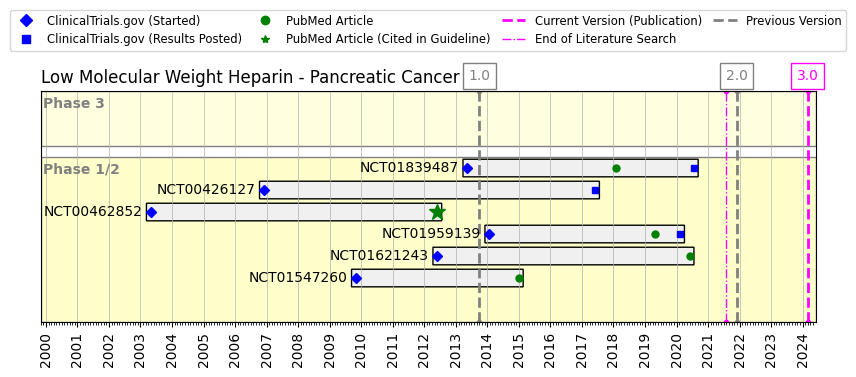

C4055109 Durvalumab lungenkarzinom


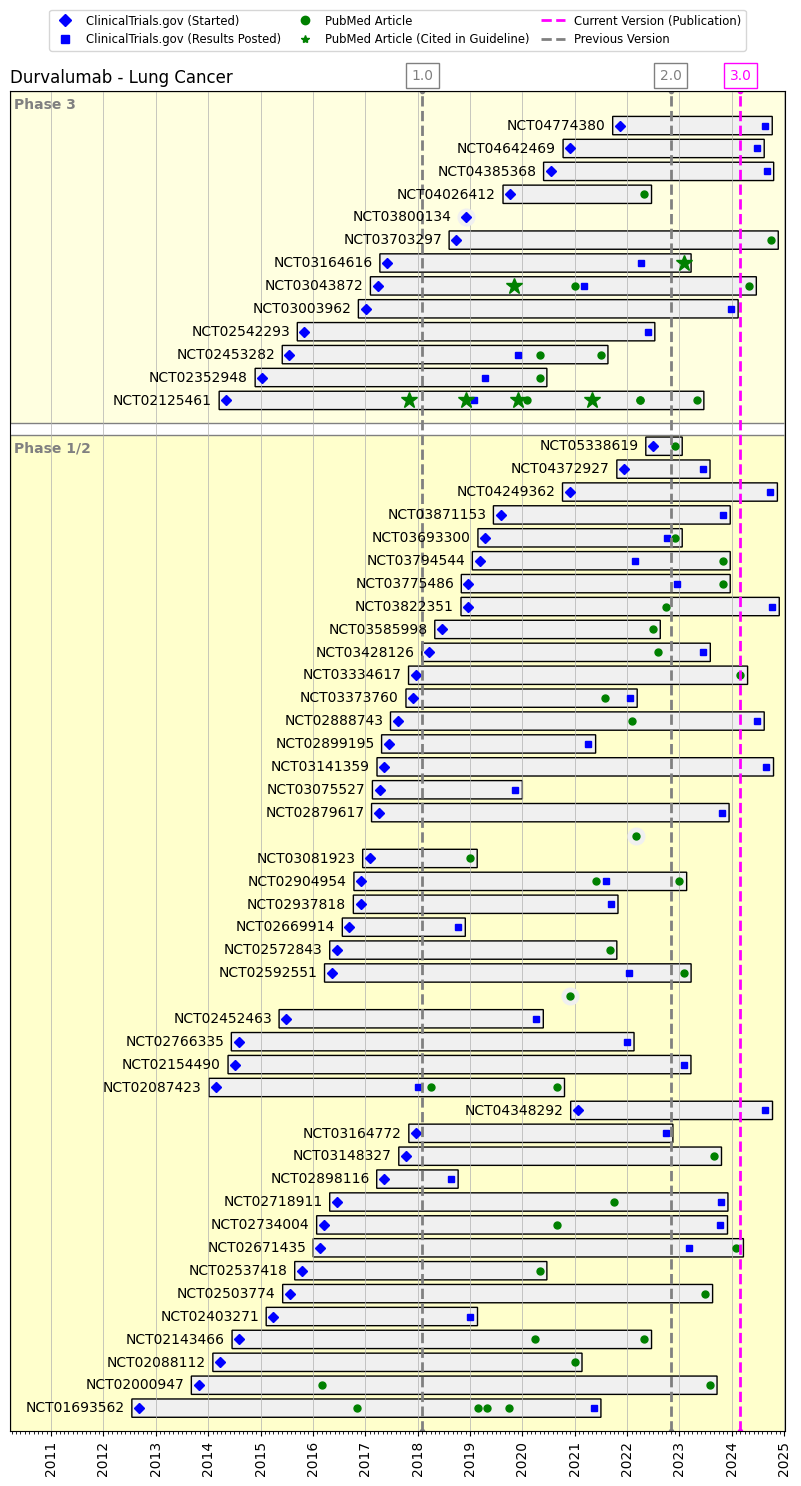

C5446297 Amivantamab lungenkarzinom


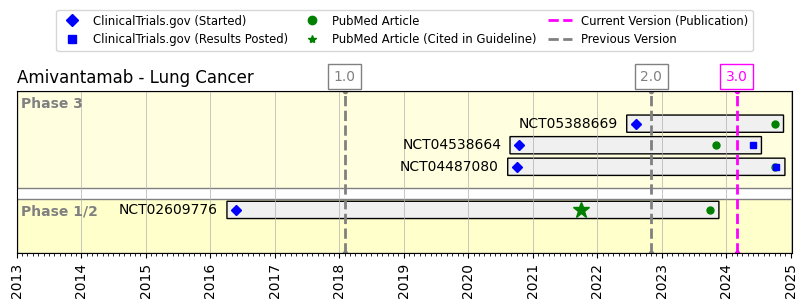

C4524909 Repotrectinib lungenkarzinom


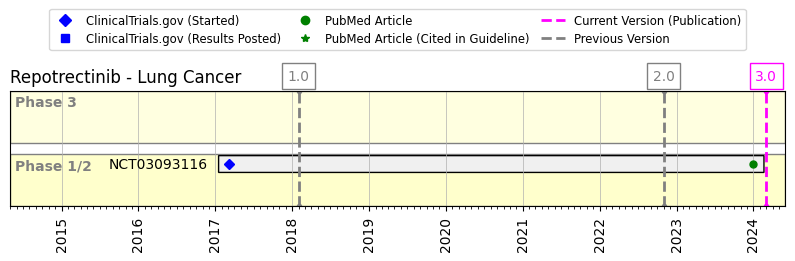

C5418250 Sotorasib pankreaskarzinom


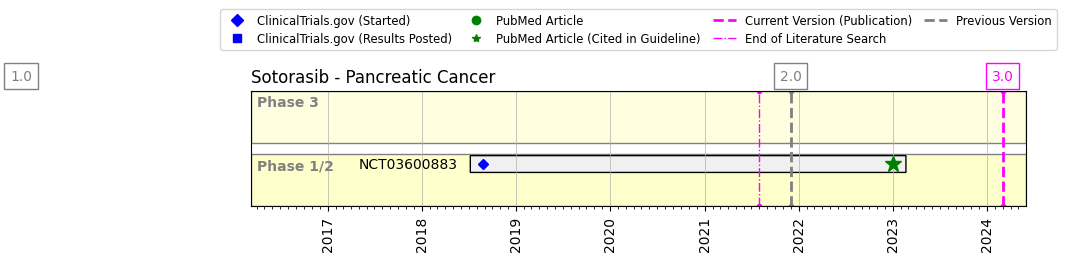

C1367202 Ipilimumab oesophaguskarzinom


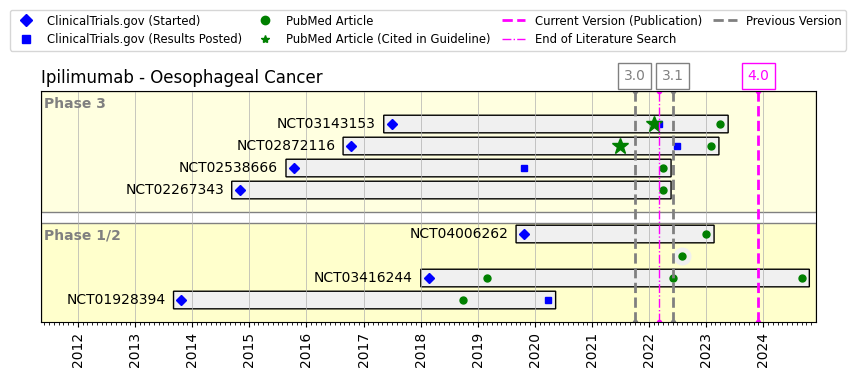

In [36]:
from api.utils import get_previous_guideline_versions
from api.viz.timelines import create_timeline_figure
from api.app import EvidenceQuery, get_evidence_by_population, get_evidence_grouped_df, get_topics
from datetime import datetime
from matplotlib import pyplot as plt

for e in examples:
    cui, guideline, min_date = e
    intv_name = app.state.concept_parser.umls_parser.get_umls_text(cui)
    print(cui, intv_name, guideline)
    
    q = EvidenceQuery(guideline_id=guideline, 
                  cuis_intervention=[cui],
                  sources=['pubmed', 'clinicaltrials'],
                  exclude_children=True)
    
    if min_date:
        min_date = datetime.strptime(min_date, "%Y-%m-%d")
    evidence_grouped_df = get_evidence_grouped_df(q, False, session)
    evidence_grouped_df = evidence_grouped_df[evidence_grouped_df.group.astype(str).str.startswith("NCT")]
    
    versions = get_previous_guideline_versions(
        app.state.topic_config, guideline, 'v2.3_2024_06_18', include_non_ggponc_versions=True)
    
    names = {t.topic_id : t.topic_en for t in topics.topics}

    fig = create_timeline_figure(
        evidence_grouped_df, versions=versions,
        intervention_name=intv_name,
        population_name=names[guideline], 
        min_date=min_date
    )
    plt.savefig(f'output/{guideline}_{intv_name.replace(" ", "_").lower()}', bbox_inches='tight', dpi=600)
    plt.show()